# Supplementary - check leakage

In this supplementary notebook, we check how different classification model would perform if we include the leaked features in our analysis (especially the last fico range)

In [42]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

## Load the raw data

In [4]:
# load teh data from the file
directory = '../Data/1805_download/'
all_files = os.listdir(directory)
output = {}
for i in all_files:
    print("    Reading file " + i)
    output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)

    Reading file LoanStats_securev1_2016Q3.csv.zip
    Reading file LoanStats_securev1_2016Q2.csv.zip
    Reading file LoanStats3a_securev1.csv.zip
    Reading file LoanStats_securev1_2017Q1.csv.zip
    Reading file LoanStats3d_securev1.csv.zip
    Reading file LoanStats_securev1_2017Q3.csv.zip
    Reading file LoanStats_securev1_2017Q2.csv.zip
    Reading file LoanStats_securev1_2016Q1.csv.zip
    Reading file LoanStats_securev1_2016Q4.csv.zip
    Reading file LoanStats3c_securev1.csv.zip
    Reading file LoanStats_securev1_2017Q4.csv.zip
    Reading file LoanStats3b_securev1.csv.zip


In [34]:
data = pd.concat([output[i] for i in output.keys()], join='inner')

data = data[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti','total_pymnt',
         'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
         'last_pymnt_amnt','fico_range_high','fico_range_low','last_fico_range_high',
         'last_fico_range_low','application_type','revol_bal','revol_util','recoveries']]

data.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                    'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs','recoveries',
                    'grade','fico_range_high','fico_range_low','installment', 'last_fico_range_high',
                    'last_fico_range_low','funded_amnt','dti','funded_amnt_inv','revol_bal','revol_util']
            ,inplace=True)
data.shape

(1761862, 36)

In [35]:
# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
            'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                'fico_range_high', 'fico_range_low','last_fico_range_low',
              'last_fico_range_high','total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

for j in float_cols:
    data[j] = pd.to_numeric(data[j])
    
for j in perc_cols:
    data[j] = data[j].str.strip('%')
    data[j] = pd.to_numeric(data[j])
    data[j] = data[j]/100

for j in date_cols:
    data[j] = pd.to_datetime(data[j])

## Engineer the features and generate the training/testing set

In [37]:
default_seed = 1
np.random.seed(default_seed)

# select only terminated loans
data = data[data.loan_status.isin(['Fully Paid','Charged Off','Default'])]

# downsample
data = data.sample(n=50000)

# create labels for the dataset
data['label'] = (data.loan_status.str.contains('Charged Off') | 
                data.loan_status.str.contains('Default'))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
data.label = data.label.astype(int)



# clean and get training/testing data 
temp = pd.get_dummies(data[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)

X = data.as_matrix(columns=['loan_amnt','funded_amnt','int_rate','installment',
                            'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                            'fico_range_high','fico_range_low','cr_hist','revol_bal',
                            'recoveries','last_fico_range_high','last_fico_range_low',
                            'revol_util', 'total_pymnt'])

X = np.concatenate((X,temp.as_matrix()),axis=1)
y = data.label.as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(35000, 66)
(15000, 66)


## Classification models

### $l_2$ penalized logistic regression

In [40]:
logisticModel = LogisticRegressionCV(cv=10,penalty='l2')
logisticModel.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [41]:
y_pred = logisticModel.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))

accuracy:  0.993733333333
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9937    0.9985    0.9961     11948
    Defaulted Loan     0.9940    0.9751    0.9845      3052

       avg / total     0.9937    0.9937    0.9937     15000

AUC:  0.996996185085


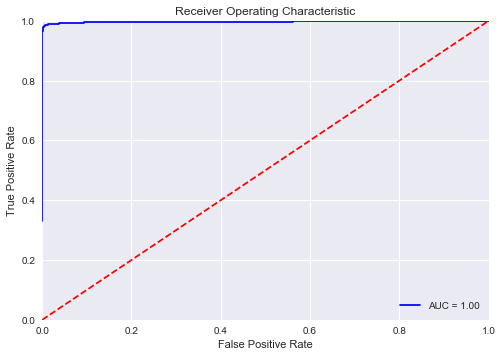

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, logisticModel.predict_proba(X_test)[:,1],
                                         pos_label=1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random forest
In addition to logistic regression, let's also take a quick look at random forest

In [45]:
random_forest = RandomForestClassifier(min_samples_leaf=100,n_estimators=50)
random_forest.fit(X_train,y_train)
y_pred = random_forest.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,random_forest.predict_proba(X_test)[:,1]))

accuracy:  0.970333333333
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9738    0.9894    0.9815     11948
    Defaulted Loan     0.9556    0.8958    0.9247      3052

       avg / total     0.9701    0.9703    0.9700     15000

AUC:  0.994910229167


As we can see, with leaked features the AUC of the models is ridiculously high